# 🧹 Introduction to Hyperparameter Sweeps using W&B

Searching through high dimensional hyperparameter spaces to find the most performant model can get unwieldy very fast. Hyperparameter sweeps provide an organized and efficient way to conduct a battle royale of models and pick the most accurate model. They enable this by automatically searching through combinations of hyperparameter values (e.g. learning rate, batch size, number of hidden layers, optimizer type) to find the most optimal values.

**Installing wandb:**

In [ ]:
!pip install wandb
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=af8ca06782d454548b0c00989c0b79aab4cc9edc4c2d9dbd234e76070374a023
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


Basic Imports for Pytorch

In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
from torch.utils.data import DataLoader


### Defining helper functions


1.   Progress Bar: To help with verbose training information and progress visualization.
2.   Cutout: A regularization tool to help with augmentation, as proposed by DeVries and Taylor (2017), https://arxiv.org/pdf/1708.04552.pdf



In [ ]:
import sys
import numpy as np
from PIL import Image


class ProgressBar:
    def __init__(self, width=30):
        self.width = width

    def update(self, max_value, current_value, info):
        progress = int(round(self.width * current_value / max_value))
        bar = '=' * progress + '.' * (self.width - progress)
        prefix = '{}/{}'.format(current_value, max_value)

        prefix_max_len = len('{}/{}'.format(max_value, max_value))
        buffer = ' ' * (prefix_max_len - len(prefix))

        sys.stdout.write('\r {} {} [{}] - {}'.format(prefix, buffer, bar, info))
        sys.stdout.flush()

    def new_line(self):
        print()


class Cutout(object):
  
    def __init__(self, num_cutouts, size, p=0.5):
        self.num_cutouts = num_cutouts
        self.size = size
        self.p = p

    def __call__(self, img):

        height, width = img.size

        cutouts = np.ones((height, width))

        if np.random.uniform() < 1 - self.p:
            return img

        for i in range(self.num_cutouts):
            y_center = np.random.randint(0, height)
            x_center = np.random.randint(0, width)

            y1 = np.clip(y_center - self.size // 2, 0, height)
            y2 = np.clip(y_center + self.size // 2, 0, height)
            x1 = np.clip(x_center - self.size // 2, 0, width)
            x2 = np.clip(x_center + self.size // 2, 0, width)

            cutouts[y1:y2, x1:x2] = 0

        cutouts = np.broadcast_to(cutouts, (3, height, width))
        cutouts = np.moveaxis(cutouts, 0, 2)
        img = np.array(img)
        img = img * cutouts
        return Image.fromarray(img.astype('uint8'), 'RGB')


# Loading the CIFAR-10 dataset.
## Additionally defining Augmentation Transformations for it and Normalizing the data.

In [ ]:
train_transform = transforms.Compose([
            Cutout(num_cutouts=2, size=8, p=0.8),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                             ])
train_dataset = datasets.CIFAR10('data/cifar', train=True, download=True, transform=train_transform)

test_dataset = datasets.CIFAR10('data/cifar', train=False, download=True, transform=test_transform)

100%|██████████| 170498071/170498071 [00:06<00:00, 28266831.83it/s]


Extracting data/cifar/cifar-10-python.tar.gz to data/cifar
Files already downloaded and verified


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##Test Function to test the model

In [ ]:
def test(model, batch_size=256):
        model.eval()

        data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(data_loader, 0):
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels.flatten()).sum().item()

        model.train()
        return correct / total

Importing the WandB Library and logging in.

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Define the sweep:** we do this by creating a dictionary or a [YAML file](https://docs.wandb.com/library/sweeps/configuration) that specifies the parameters to search through, the search strategy, the optimization metric et all.


In [ ]:
sweep_config = {
    'method': 'random'
    }

sweep_config['metric'] = {
    'name': 'accuracy',
    'goal': 'maximize'
    }

sweep_config['parameters'] = {
        'learning_rate': {
            'values': [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
        }, 
        'optimizer': {
            'values': ['adam', 'sgd']
        },
        'batch_size': {
            'values': [128, 256, 512]
        },
        'epochs': {
            'values': [50,75,100,150,200]
        },
        'activation': {
            'values': ['relu', 'sigmoid']
        },
        'fc_size': {
            'values': [1024, 2048]
        },
        'dropout': {
            'values': [0.25, 0.5]
        }
    }


import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'accuracy'},
 'parameters': {'activation': {'values': ['relu', 'sigmoid']},
                'batch_size': {'values': [128, 256, 512]},
                'dropout': {'values': [0.25, 0.5]},
                'epochs': {'values': [50, 75, 100, 150, 200]},
                'fc_size': {'values': [1024, 2048]},
                'learning_rate': {'values': [1e-05,
                                             5e-05,
                                             0.0001,
                                             0.0005,
                                             0.001]},
                'optimizer': {'values': ['adam', 'sgd']}}}


###Defining helper functions for the WandB sweeps

In [ ]:
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

#Model Definition for hyperparameter sweep.
This is a modified ResNet model, with the architecture shown below.

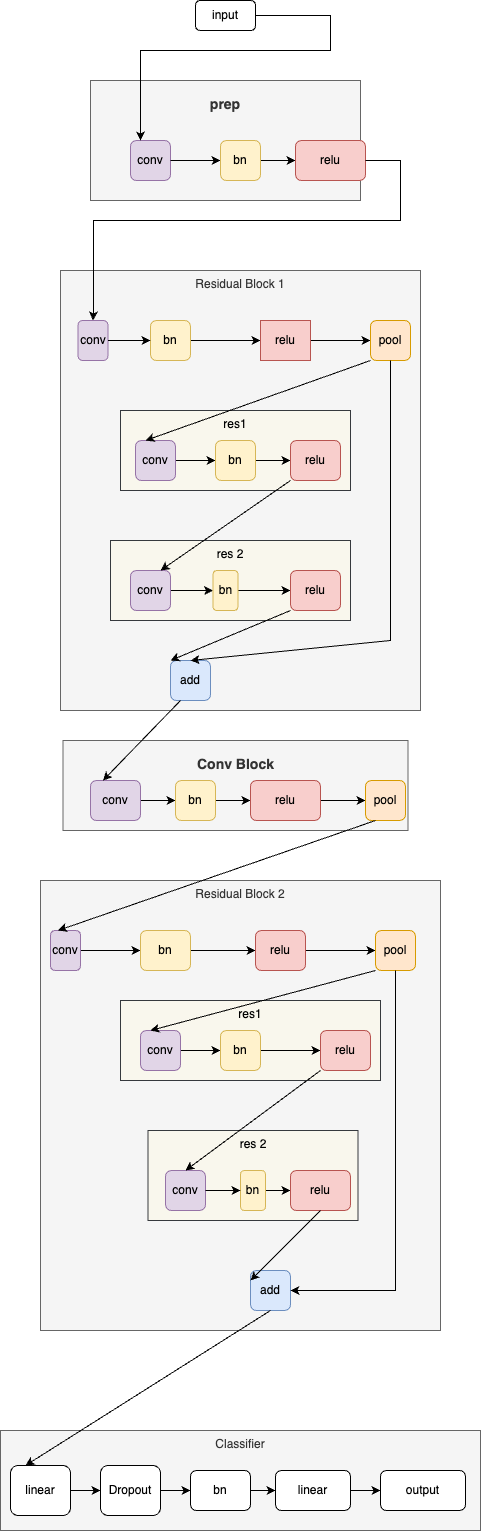

In [ ]:
class BasicBlock(nn.Module):#Residual Block
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out


class ResNet9(nn.Module):
    def __init__(self, activation='relu', fc_size=1024, dropout=0.5):
        super(ResNet9, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        if activation == "relu":
            self.fc = nn.Sequential(
                nn.Linear(in_features=1024, out_features=fc_size, bias=True),
                nn.Dropout(p=dropout),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(num_features=fc_size, momentum=0.9),
                nn.Linear(in_features=fc_size, out_features=10, bias=True)
            )
        elif activation == "sigmoid":
            self.fc = nn.Sequential(
                nn.Linear(in_features=1024, out_features=fc_size, bias=True),
                nn.Dropout(p=dropout),
                nn.Sigmoid(),
                nn.BatchNorm1d(num_features=fc_size, momentum=0.9),
                nn.Linear(in_features=fc_size, out_features=10, bias=True)
            )
        

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out

#Define the training function for Hyperparameter Sweep
The function also diplays the number of parameters in the model as the model is changed as per WandB config.

The sweep agent calls this function and it supplies multiple parameters for training, one by one.


In [ ]:
def train_wb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        model = ResNet9(activation=config.activation, fc_size=config.fc_size, dropout=config.dropout).to(device)
        print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate)
        model.train()
        criterion = nn.CrossEntropyLoss()
        trainloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        
        progress_bar = ProgressBar()
        
        for epoch in range(1, config.epochs + 1):
            print('Epoch {}/{}'.format(epoch, config.epochs))
            running_loss = 0
            epoch_correct = 0
            epoch_total = 0
            for i, (inputs, targets) in enumerate(trainloader):

                inputs, targets = inputs.to(device), targets.to(device)

          
                optimizer.zero_grad()

                # Forward + backward + optimizer
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                # Update stats
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                batch_total = targets.size(0)
                batch_correct = predicted.eq(targets).sum().item()


                epoch_total += batch_total
                epoch_correct += batch_correct

                
                info_str = 'Last batch accuracy: {:.4f} - Running epoch accuracy {:.4f}'.\
                            format(batch_correct / batch_total, epoch_correct / epoch_total)
                progress_bar.update(max_value=len(trainloader), current_value=i, info=info_str)

            progress_bar.new_line()
            test_accuracy = test(model)
            print('Test accuracy: {:.2f}% Loss: {:.4f}'.format(test_accuracy*100,running_loss))
            wandb.log({"accuracy": test_accuracy*100, "epoch": epoch})  

**Initializing the sweep:** and  **Running the sweep agent:** 
The sweep can be viewed on https://wandb.ai/brijendra/DL_Mini/sweeps/goj8y2ak

We need to run this from multiple machines or computes and all the data is collected on the project. 

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DL_Mini")
sweep_id = "goj8y2ak"
wandb.agent(sweep_id, train_wb, count = 5)

Create sweep with ID: 6hr7nr28
Sweep URL: https://wandb.ai/brijendra/DL_Mini/sweeps/6hr7nr28


wandb: Agent Starting Run: 6b0ka3ad with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 50
wandb: 	fc_size: 2048
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: Currently logged in as: bka2022 (brijendra). Use `wandb login --relogin` to force relogin


Number of trainable parameters: 4561482
Epoch 1/50
 195/196  [==============================] - Last batch accuracy: 0.4875 - Running epoch accuracy 0.3816
Test accuracy: 52.31% Loss: 329.7075
Epoch 2/50
 195/196  [==============================] - Last batch accuracy: 0.5375 - Running epoch accuracy 0.5425
Test accuracy: 61.82% Loss: 248.6424
Epoch 3/50
 195/196  [==============================] - Last batch accuracy: 0.6375 - Running epoch accuracy 0.6165
Test accuracy: 66.58% Loss: 209.5139
Epoch 4/50
 195/196  [==============================] - Last batch accuracy: 0.7125 - Running epoch accuracy 0.6642
Test accuracy: 71.79% Loss: 184.9002
Epoch 5/50
 195/196  [==============================] - Last batch accuracy: 0.7500 - Running epoch accuracy 0.6989
Test accuracy: 73.72% Loss: 167.3610
Epoch 6/50
 195/196  [==============================] - Last batch accuracy: 0.7375 - Running epoch accuracy 0.7241
Test accuracy: 74.60% Loss: 153.8420
Epoch 7/50
 195/196  [====================

accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇███████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,89.06
epoch,50


wandb: Agent Starting Run: w6jpn9wa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 75
wandb: 	fc_size: 2048
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Number of trainable parameters: 4561482
Epoch 1/75
 390/391  [==============================] - Last batch accuracy: 0.5375 - Running epoch accuracy 0.4076
Test accuracy: 55.75% Loss: 625.0015
Epoch 2/75
 390/391  [==============================] - Last batch accuracy: 0.5125 - Running epoch accuracy 0.5806
Test accuracy: 66.37% Loss: 463.8733
Epoch 3/75
 390/391  [==============================] - Last batch accuracy: 0.7125 - Running epoch accuracy 0.6582
Test accuracy: 71.47% Loss: 385.8069
Epoch 4/75
 390/391  [==============================] - Last batch accuracy: 0.7750 - Running epoch accuracy 0.7026
Test accuracy: 74.71% Loss: 340.7283
Epoch 5/75
 390/391  [==============================] - Last batch accuracy: 0.8000 - Running epoch accuracy 0.7320
Test accuracy: 79.34% Loss: 308.0669
Epoch 6/75
 390/391  [==============================] - Last batch accuracy: 0.8000 - Running epoch accuracy 0.7590
Test accuracy: 78.68% Loss: 281.3458
Epoch 7/75
 390/391  [====================

accuracy,▁▃▅▅▆▆▇▇▇▇▇▇████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,92.62
epoch,75


wandb: Agent Starting Run: eqq125nt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 50
wandb: 	fc_size: 1024
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Number of trainable parameters: 3499594
Epoch 1/50
 195/196  [==============================] - Last batch accuracy: 0.5375 - Running epoch accuracy 0.4079
Test accuracy: 56.57% Loss: 314.1778
Epoch 2/50
 195/196  [==============================] - Last batch accuracy: 0.5500 - Running epoch accuracy 0.5938
Test accuracy: 67.77% Loss: 223.4835
Epoch 3/50
 195/196  [==============================] - Last batch accuracy: 0.7375 - Running epoch accuracy 0.6726
Test accuracy: 72.94% Loss: 182.8523
Epoch 4/50
 195/196  [==============================] - Last batch accuracy: 0.7250 - Running epoch accuracy 0.7164
Test accuracy: 74.62% Loss: 161.0245
Epoch 5/50
 195/196  [==============================] - Last batch accuracy: 0.7500 - Running epoch accuracy 0.7448
Test accuracy: 78.44% Loss: 145.8299
Epoch 6/50
 195/196  [==============================] - Last batch accuracy: 0.7375 - Running epoch accuracy 0.7699
Test accuracy: 78.68% Loss: 133.2417
Epoch 7/50
 195/196  [====================

accuracy,▁▃▄▅▅▆▆▇▆▇▇▇▇▇▇▇████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,91.03
epoch,50


wandb: Agent Starting Run: qzoh25pr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 50
wandb: 	fc_size: 2048
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd


Number of trainable parameters: 4561482
Epoch 1/50
 390/391  [==============================] - Last batch accuracy: 0.2125 - Running epoch accuracy 0.1383
Test accuracy: 19.04% Loss: 916.7143
Epoch 2/50
 390/391  [==============================] - Last batch accuracy: 0.1500 - Running epoch accuracy 0.1847
Test accuracy: 24.31% Loss: 859.8646
Epoch 3/50
 390/391  [==============================] - Last batch accuracy: 0.2125 - Running epoch accuracy 0.2185
Test accuracy: 26.93% Loss: 825.5745
Epoch 4/50
 390/391  [==============================] - Last batch accuracy: 0.2125 - Running epoch accuracy 0.2393
Test accuracy: 29.35% Loss: 801.7540
Epoch 5/50
 390/391  [==============================] - Last batch accuracy: 0.1875 - Running epoch accuracy 0.2550
Test accuracy: 30.97% Loss: 783.5818
Epoch 6/50
 390/391  [==============================] - Last batch accuracy: 0.3000 - Running epoch accuracy 0.2729
Test accuracy: 32.13% Loss: 766.1151
Epoch 7/50
 390/391  [====================

accuracy,▁▂▂▃▃▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,59.67
epoch,50


wandb: Agent Starting Run: bkwvbczc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 100
wandb: 	fc_size: 1024
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Number of trainable parameters: 3499594
Epoch 1/100
 390/391  [==============================] - Last batch accuracy: 0.4625 - Running epoch accuracy 0.4050
Test accuracy: 55.50% Loss: 634.9000
Epoch 2/100
 390/391  [==============================] - Last batch accuracy: 0.7000 - Running epoch accuracy 0.5600
Test accuracy: 65.85% Loss: 477.7667
Epoch 3/100
 390/391  [==============================] - Last batch accuracy: 0.6375 - Running epoch accuracy 0.6297
Test accuracy: 69.54% Loss: 404.7055
Epoch 4/100
 390/391  [==============================] - Last batch accuracy: 0.6375 - Running epoch accuracy 0.6756
Test accuracy: 73.53% Loss: 358.1347
Epoch 5/100
 390/391  [==============================] - Last batch accuracy: 0.7250 - Running epoch accuracy 0.7071
Test accuracy: 75.20% Loss: 326.3976
Epoch 6/100
 390/391  [==============================] - Last batch accuracy: 0.6625 - Running epoch accuracy 0.7314
Test accuracy: 77.04% Loss: 301.5164
Epoch 7/100
 390/391  [=============

accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,90.44
epoch,100


After Running the Sweep more than 50 times with multiple parameters, we can look at the hyperparameters with the best accuracy results and use it to train the best model.


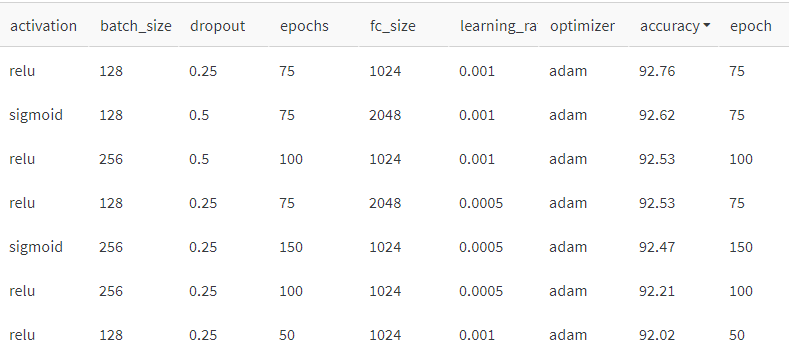

Parameter Importance, w.r.t. test accuracy
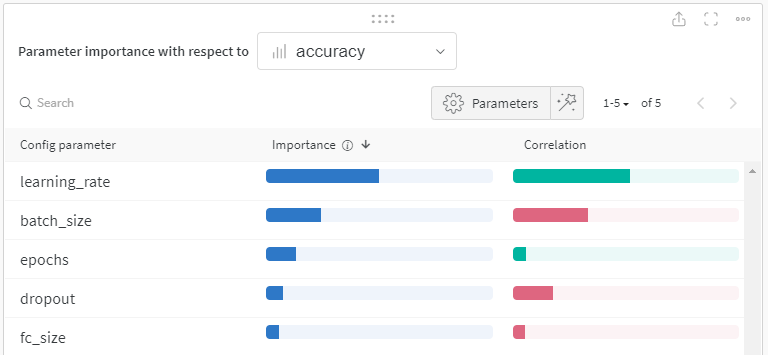